-----
### Installing Pyspark

The below commented out code is to be used if spark installation and kaggle is not working, an alternative to the kaggle api is to follow the kaggle link to the dataset further below and manually download it.

**Sentiment140 dataset with 1.6 million tweets** - https://www.kaggle.com/datasets/kazanova/sentiment140/code

In [ ]:
#!pip install pyspark py4j

### Setting Kaggle Evironment to download kaggle dataset

In [ ]:
#!pip install -q kaggle

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
#! mkdir ~/.kaggle

In [ ]:
#! cp kaggle.json ~/.kaggle/

In [ ]:
#! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets list

In [ ]:
#!kaggle datasets download -d kazanova/sentiment140

In [ ]:
#!unzip sentiment140.zip

-----
## What is a Recurrent Neural Network (RNN)?

https://www.ibm.com/topics/recurrent-neural-networks

Recurrent Neural Network is a type of artifical neural network which is used for sequential or time series data.

Reasons for using RNN is for Language Translation, Natural Language Processing (NLP), Speech Recognition, and Image Captioning.







----
## Why the Dataset is Suitable for RNN?

**Sentiment140 dataset with 1.6 million tweets** - https://www.kaggle.com/datasets/kazanova/sentiment140/code

The dataset accessed from kaggle which was uploaded by ΜΑΡΙΟΣ ΜΙΧΑΗΛΙΔΗΣ KAZANOVA is of 1.6 Million tweets from Twitter.

The dataset holds 6 columns [target, ids, date, flag, user, text].

**The dataset is acceptable for it satisfies one of the reasons why RNN would be used, Sentiment analysis.**

### Process to be followed:

The columns which will be used is the target and text columns which will be renamed to label (target), and tweet (text).

* Addtionally, for the label (target) there are 3 outcomes: 0 (negative), 2 (neutral) and 4 (positive). However, for this model it will only be evaluating on if a tweet is negative or positive, thus some cleaning of the data will be necessary.

* The cleaning of the data will first consist of extracting a sample of 25% (approximately 400 000)  of the whole dataset, this 25% will be used for the training and testing of the model.

* Second, the dataset will be checked for any missing or null entires, after which the columns beside label and tweet will be dropped for they are not needed for this model.

* Third, the label entries with a value of 4 will be replaced with 1, reason being so it is more representative of a binary yes or no (positive or negative), and will be easier to understand.

* Lastly, the raw tweet text will be processed, simply removing the punctuation and this along side the label will be used to for the model's training, which will be built and evaluated based on a graph of the accuracy, vs validating accuracy.

----
### Imports





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import string
import random
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, Flatten, Dropout
from keras.layers import Embedding
from keras.preprocessing import sequence

### Create SparkSession

In [ ]:
spark = SparkSession.builder.appName("1,6 Million Tweets").getOrCreate()

### Load the dataset and create sprk dataframe.

In [ ]:
df = spark.read.csv("training.1600000.processed.noemoticon.csv",
                    sep=",",
                    inferSchema="true",
                    header="false"
                    ).toDF('label', 'id', 'time', 'flag', 'user', 'tweet')

df.count()

1600000

## Help with Spark Commands

https://www.analyticsvidhya.com/blog/2021/05/9-most-useful-functions-for-pyspark-dataframe/



###Number of entries labeled 0 (Negative).

In [ ]:
df.filter(df.label == 0).count()

800000

### Number of entries labeled 2 (Neutral).

In [ ]:
df.filter(df.label == 2).count()

0

###Number of entries labeled 0 (Negative).

In [ ]:
df.filter(df.label == 4).count()

800000

###Checking for any nulls in the label column.

In [ ]:
df.filter(df.label.isNull()).count()

0

###Checking for any nulls in the tweet column

In [ ]:
df.filter(df.tweet.isNull()).count()

0

-----------
### Getting a sample of 25% from the 1,6 Million Tweets

25% of 1,6 Million equals 400000 rows.

https://saturncloud.io/blog/random-sampling-from-a-dataframe-in-pyspark-a-comprehensive-guide/#:~:text=By%20using%20the%20sample(),understanding%20of%20how%20it%20works.

In [ ]:
df = df.sample(withReplacement=False, fraction=0.25, seed=2)

df.count()

398919

In [ ]:
df.limit(5).toPandas()

,label,id,time,flag,user,tweet
0,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
1,0,1467812723,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,TLeC,@caregiving I couldn't bear to watch it. And ...
2,0,1467812771,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,robrobbierobert,"@octolinz16 It it counts, idk why I did either..."
3,0,1467812799,Mon Apr 06 22:20:20 PDT 2009,NO_QUERY,HairByJess,@iamjazzyfizzle I wish I got to watch it with ...
4,0,1467813579,Mon Apr 06 22:20:31 PDT 2009,NO_QUERY,starkissed,@LettyA ahh ive always wanted to see rent lov...


-------
### Converting Spark Dataframe to Pandas Dataframe & Evaluation

Converting Spark Df to Pandas Df to be able to use Pandas functions.

In [ ]:
df_Pandas = df.toPandas()

### Checking the names of each column in the dataset.

In [ ]:
df_Pandas.columns

Index(['label', 'id', 'time', 'flag', 'user', 'tweet'], dtype='object')

### Dropping all irrelevant columns, keeping only label and tweet.

In [ ]:
df_Pd = df_Pandas.drop(['id', 'time', 'flag', 'user'], axis= 1)

In [ ]:
df_Pd.head()

,label,tweet
0,0,@twittera que me muera ?
1,0,@caregiving I couldn't bear to watch it. And ...
2,0,"@octolinz16 It it counts, idk why I did either..."
3,0,@iamjazzyfizzle I wish I got to watch it with ...
4,0,@LettyA ahh ive always wanted to see rent lov...


### Checking visually the spread of entries between positive and negative, to ensure they are close to the same spread as the original dataset.

<Axes: xlabel='label', ylabel='count'>

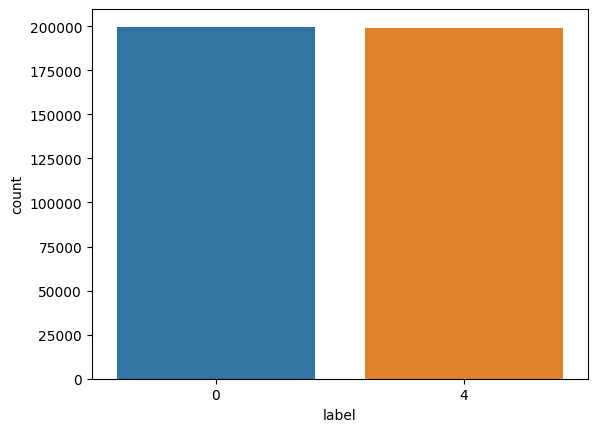

In [ ]:
sb.countplot(data=df_Pandas, x='label')

### Number of entries in sample labeled 0 (Negative).




In [ ]:
df.filter(df.label == 0).count()

199689

### Number of entries in sample labeled 2 (Neutral).

In [ ]:
df.filter(df.label == 2).count()

0

### Number of entries in sample labeled 4 (Positive).

In [ ]:
df.filter(df.label == 4).count()

199230

### Seeing if there are any null entries within label column.




In [ ]:
df.filter(df.label.isNull()).count()

0

### Checking if there are any null entries within tweet column.

In [ ]:
 df.filter(df.tweet.isNull()).count()

0

------
### Replacing label 4 with 1

**0 = negative**

**1 = positive**

### Replacing entires in label column with a 4 to 1, reason standardizing the data.

In [ ]:
df_Pd['label'] = df_Pd['label'].replace(4,1)
df_Pd

,label,tweet
0,0,@twittera que me muera ?
1,0,@caregiving I couldn't bear to watch it. And ...
2,0,"@octolinz16 It it counts, idk why I did either..."
3,0,@iamjazzyfizzle I wish I got to watch it with ...
4,0,@LettyA ahh ive always wanted to see rent lov...
...,...,...
398914,1,@thrillmesoon i figured out how to see my twee...
398915,1,@Ms_Hip_Hop im glad ur doing well
398916,1,WOOOOO! Xbox is back
398917,1,Are you ready for your MoJo Makeover? Ask me f...


### Getting the length of each tweet.

In [ ]:
df_Pd['tweet_len'] = df_Pd.tweet.apply(len)

In [ ]:
df_Pd

,label,tweet,tweet_len
0,0,@twittera que me muera ?,25
1,0,@caregiving I couldn't bear to watch it. And ...,94
2,0,"@octolinz16 It it counts, idk why I did either...",77
3,0,@iamjazzyfizzle I wish I got to watch it with ...,103
4,0,@LettyA ahh ive always wanted to see rent lov...,64
...,...,...,...
398914,1,@thrillmesoon i figured out how to see my twee...,135
398915,1,@Ms_Hip_Hop im glad ur doing well,34
398916,1,WOOOOO! Xbox is back,21
398917,1,Are you ready for your MoJo Makeover? Ask me f...,57


### Ploting the length of tweets against their label.

To see if their is any visiable correlation between tweet length and its label of being either negative or positive.

Text(0.5, 0, 'Tweet Length')

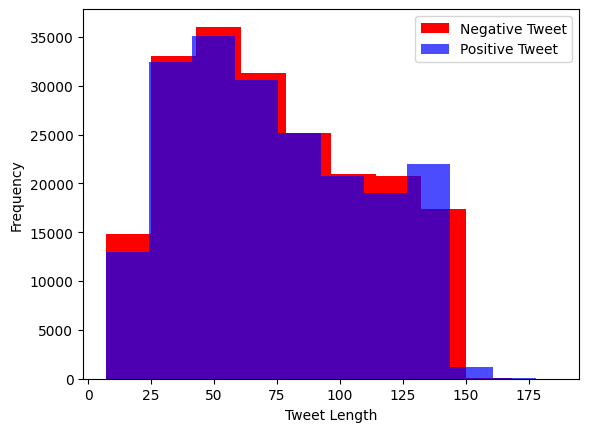

In [ ]:
plt.figure()
df_Pd[df_Pd.label==0].tweet_len.plot(kind='hist', color='red', label='Negative Tweet', alpha=1)
df_Pd[df_Pd.label==1].tweet_len.plot(kind='hist', color='blue', label='Positive Tweet', alpha=0.7)
plt.legend()
plt.xlabel("Tweet Length")

-------
### Text Processing of Tweets

https://www.tutorialspoint.com/python_text_processing/python_tokenization.htm

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
type(stopwords.words('english'))

list

In [ ]:
def tweet_process(tweet):
    STOPWORDS = stopwords.words('english')

    nopunc = [char for char in tweet if char not in string.punctuation]
    nopunc = ''.join(nopunc)

    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [ ]:
df_Pd['clean_tweet'] = df_Pd.tweet.apply(tweet_process)
df_Pd.head()

,label,tweet,tweet_len,clean_tweet
0,0,@twittera que me muera ?,25,twittera que muera
1,0,@caregiving I couldn't bear to watch it. And ...,94,caregiving couldnt bear watch thought UA loss ...
2,0,"@octolinz16 It it counts, idk why I did either...",77,octolinz16 counts idk either never talk anymore
3,0,@iamjazzyfizzle I wish I got to watch it with ...,103,iamjazzyfizzle wish got watch miss iamlilnicki...
4,0,@LettyA ahh ive always wanted to see rent lov...,64,LettyA ahh ive always wanted see rent love sou...


-----
### Splitting the Data

In [ ]:
X = df_Pd['clean_tweet']
y = df_Pd['label']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((319135,), (79784,))

In [ ]:
y_train.shape, y_test.shape

((319135,), (79784,))

In [ ]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X)
tokenizer.num_words = vocab_length

In [ ]:
input_length = 60

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

In [ ]:
print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (319135, 60)
X_test.shape : (79784, 60)


------
### Model

In [ ]:
embedding_dim = 32
max_tweet_length = 60

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_length, output_dim=embedding_dim, input_length=max_tweet_length))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 32)            1920000   
                                                                 
 dropout_4 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1937025 (7.39 MB)
Trainable params: 1937

### Starting Epoch training

In [ ]:
train_history = model.fit(X_train, y_train, batch_size=32, epochs= 5, verbose=2, validation_split=0.2)

Epoch 1/5
7979/7979 - 370s - loss: 0.4894 - accuracy: 0.7616 - val_loss: 0.4677 - val_accuracy: 0.7771 - 370s/epoch - 46ms/step
Epoch 2/5
7979/7979 - 351s - loss: 0.4184 - accuracy: 0.8052 - val_loss: 0.4611 - val_accuracy: 0.7814 - 351s/epoch - 44ms/step
Epoch 3/5
7979/7979 - 351s - loss: 0.3749 - accuracy: 0.8295 - val_loss: 0.4713 - val_accuracy: 0.7784 - 351s/epoch - 44ms/step
Epoch 4/5
7979/7979 - 350s - loss: 0.3373 - accuracy: 0.8504 - val_loss: 0.5060 - val_accuracy: 0.7719 - 350s/epoch - 44ms/step
Epoch 5/5
7979/7979 - 348s - loss: 0.3025 - accuracy: 0.8671 - val_loss: 0.5345 - val_accuracy: 0.7655 - 348s/epoch - 44ms/step


In [ ]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Train History Graph ( Accuracy VS Epoch )

https://saturncloud.io/blog/what-is-higher-validation-accuracy-than-training-accuracy-in-tensorflow-and-keras/#:~:text=in%20machine%20learning.-,Validation%20accuracy%20is%20the%20accuracy%20of%20a%20model%20on%20new,seen%20the%20validation%20data%20before.

The below graph displays two lines, the blue being the accuracy of the model of the training data, whilst the validation is the accuracy of test data.

The graph shows the accuracy scored based on the number of Epochs that were iterated through.

With it indicating on the graph that the best accuracy scored by the model on test data was during the first epoch, where as with every epoch iterated the training accuracy increased.


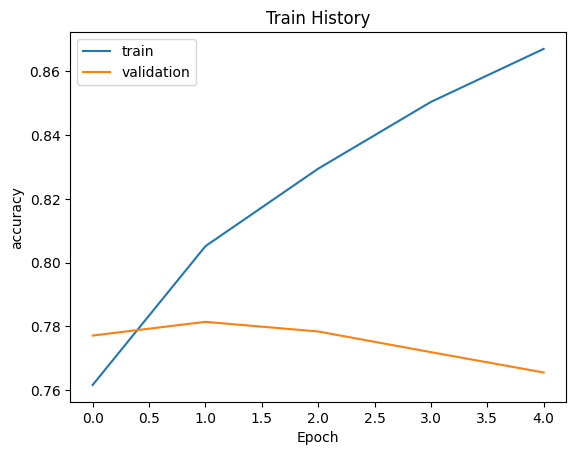

In [ ]:
show_train_history(train_history,'accuracy','val_accuracy')

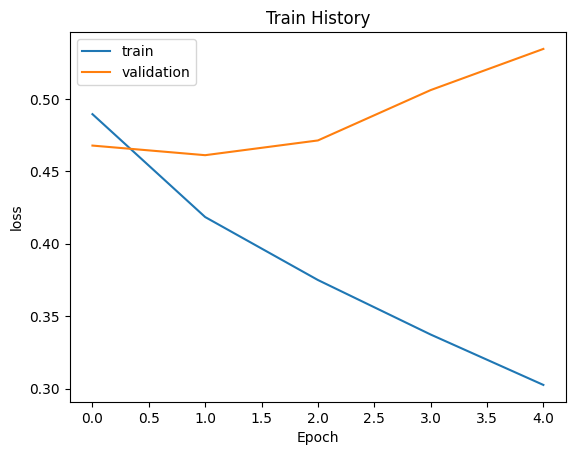

In [ ]:
show_train_history(train_history,'loss','val_loss')

### Final Accuracy Check for the Model:

The accuracy of the model came to 0.768 which equates to a 76.8% accuracy for the model.

Meaning that the model is likly to be 76.8% correct when predicting a tweets label of either being negative or positive.

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
scores[1]

2494/2494 [==============================] - 18s 7ms/step - loss: 0.5334 - accuracy: 0.7681


0.7681490182876587